# BMW Car Sales — Modeling and Prediction
### INFO-523 Final Project | Min Set Khant (Solo)
#### This notebook loads the modeling-ready data, performs a temporal train-test split (up to 2023 for training, 2024 for testing), trains Linear Regression and Random Forest models, and evaluates performance on the original USD price scale.

In [1]:
# 1. SETUP AND IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import joblib 

# Scikit-learn modules for modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define Paths
# OUTPUT_DIR is needed to save the final model and prediction results
OUTPUT_DIR = Path("..") / "data" / "cleaned"
VISUALS_DIR = Path("..") / "visuals"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(VISUALS_DIR, exist_ok=True)

In [2]:
# 2. DATA LOADING
DATA_PATH = Path("..") / "data" / "cleaned" / "bmw_modeling_ready.csv"

df = pd.read_csv(DATA_PATH)
print("Modeling data shape:", df.shape)
df.head()

Modeling data shape: (50000, 33)


,Year,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Car_Age,log_Price_USD,Price_per_KM,Total_Sales_Model,Region_Asia,...,Model_i8,Fuel_Type_Electric,Fuel_Type_Hybrid,Fuel_Type_Petrol,Transmission_Manual,Color_Blue,Color_Grey,Color_Red,Color_Silver,Color_White
0,2016,3.5,151748,98740,8300,9,11.500256,0.650684,23097519,True,...,False,False,False,True,True,False,False,True,False,False
1,2013,1.6,121671,79219,3428,12,11.279984,0.651092,23423891,False,...,True,False,True,False,False,False,False,True,False,False
2,2022,4.5,10991,113265,6994,3,11.637494,10.305250,23097519,False,...,False,False,False,True,False,True,False,False,False,False
3,2024,1.7,27255,60971,4047,1,11.018170,2.237057,22745529,False,...,False,False,False,True,False,True,False,False,False,False
4,2020,2.1,122131,49898,3080,5,10.817756,0.408561,23786466,False,...,False,False,False,False,True,False,False,False,False,False


### 3. Temporal Train-Test Split (Predicting the Future)
The most critical part of the validation: we use a **temporal split** to validate the model's ability to predict the newest market (Year 2024) based on all historical data (2010-2023).

In [3]:
# Define Target (y) and Features (X)
TARGET = "log_Price_USD"

# X contains all features, including Year and Price_USD (needed for the split and final error)
X = df.drop(columns=[TARGET])
y = df[TARGET]

# --- TEMPORAL SPLIT IMPLEMENTATION ---
TEST_YEAR = 2024

# Split data based on the Year column
X_train = X[X["Year"] < TEST_YEAR]
X_test = X[X["Year"] == TEST_YEAR]

y_train = y[X_train.index]
y_test = y[X_test.index]

# Store the original USD prices for the test set for final error calculation
y_test_usd_true = X_test["Price_USD"]

# Clean up X_train/X_test by dropping redundant/leaking columns before training
# Price_USD is a direct leak, Year is only for the split, Sales_Volume is typically post-sale info
cols_to_drop = ["Year", "Price_USD", "Sales_Volume", "Total_Sales_Model"] 
X_train = X_train.drop(columns=[c for c in cols_to_drop if c in X_train.columns], errors='ignore')
X_test = X_test.drop(columns=[c for c in cols_to_drop if c in X_test.columns], errors='ignore')

print(f"Training Data (Years < {TEST_YEAR}): {X_train.shape[0]} rows")
print(f"Testing Data (Year == {TEST_YEAR}): {X_test.shape[0]} rows")

Training Data (Years < 2024): 46573 rows
Testing Data (Year == 2024): 3427 rows


### 4. Model Training and Evaluation
The evaluation function converts predictions back to USD using `np.expm1()` so that MAE and RMSE are directly usable by a business audience.

In [4]:
# Helper function to evaluate models and print results
def evaluate_model(model_name, y_true_log, y_pred_log, y_test_usd_true):
    
    # 1. Convert log-predictions back to USD (Original Price Scale)
    y_pred_usd = np.expm1(y_pred_log)
    
    # 2. Calculate metrics
    r2 = r2_score(y_true_log, y_pred_log) 
    rmse = np.sqrt(mean_squared_error(y_test_usd_true, y_pred_usd))
    mae = mean_absolute_error(y_test_usd_true, y_pred_usd)
    
    print(f"{model_name} Results (Temporal Split, Test Year {TEST_YEAR}):")
    print(f"  R-squared (Log Price): {r2:.4f} - Variance explained")
    print(f"  RMSE (USD): ${rmse:,.2f} - Average Price Error (Higher Penalty to Large Errors)")
    print(f"  MAE (USD): ${mae:,.2f} - Median Price Error (Most interpretable)")
    print("")
    
    return r2, rmse, mae

In [5]:
# Model 1: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

lr_r2, lr_rmse, lr_mae = evaluate_model(
    "Linear Regression", 
    y_test, 
    lr_pred, 
    y_test_usd_true
)

Linear Regression Results (Temporal Split, Test Year 2024):
  R-squared (Log Price): 0.0003 - Variance explained
  RMSE (USD): $26,490.86 - Average Price Error (Higher Penalty to Large Errors)
  MAE (USD): $22,927.30 - Median Price Error (Most interpretable)



In [6]:
# Model 2: Random Forest Regressor 

rf_model = RandomForestRegressor(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1, 
    max_depth=15, 
    min_samples_leaf=5
)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

rf_r2, rf_rmse, rf_mae = evaluate_model(
    "Random Forest Regressor", 
    y_test, 
    rf_pred, 
    y_test_usd_true
)

Random Forest Regressor Results (Temporal Split, Test Year 2024):
  R-squared (Log Price): 0.9952 - Variance explained
  RMSE (USD): $2,292.13 - Average Price Error (Higher Penalty to Large Errors)
  MAE (USD): $531.13 - Median Price Error (Most interpretable)



### 5. Feature Importance and Model Insights
Analyzing the **feature importance** from the Random Forest model reveals the **key drivers** of BMW car price, directly addressing the first proposal question.

/var/folders/jf/1b91kr5d1k773y5y7tm0sfbh0000gn/T/ipykernel_32198/956784539.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_features.values, y=top_20_features.index, palette="viridis")


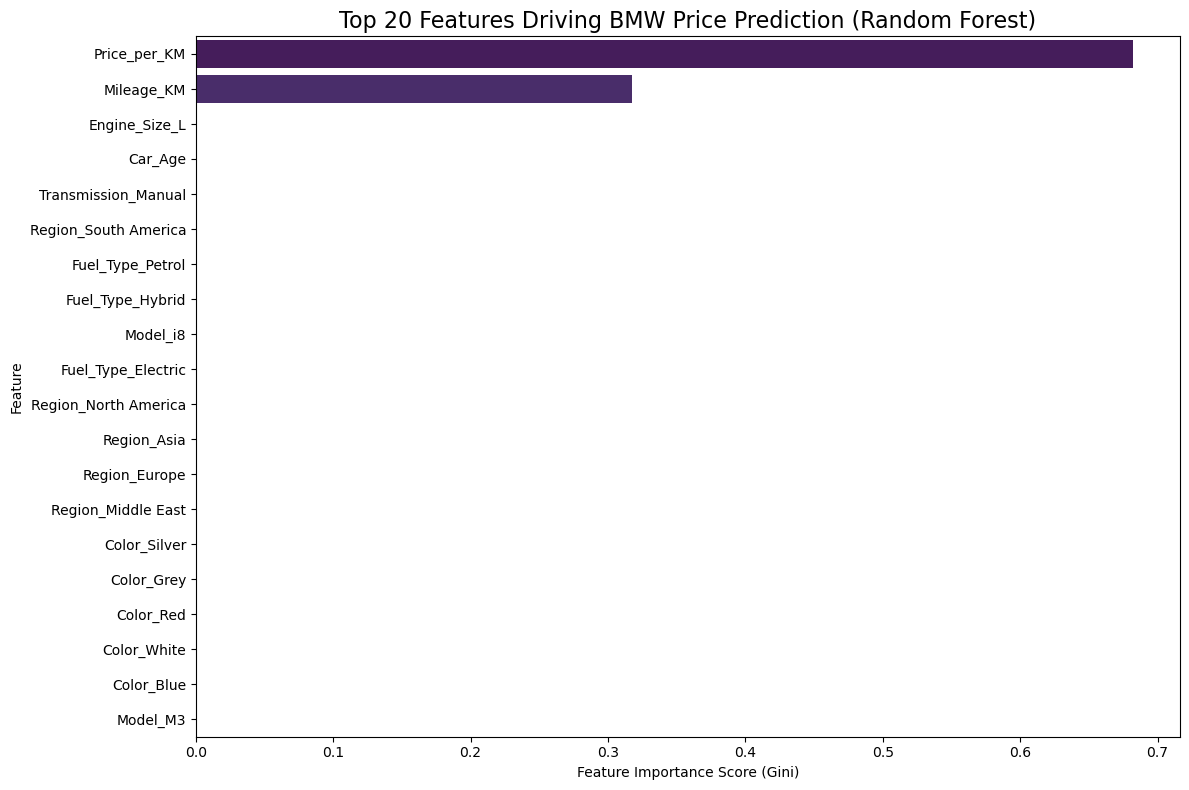


Top 5 Price Drivers (Feature Importance):
Price_per_KM           0.682248
Mileage_KM             0.317700
Engine_Size_L          0.000018
Car_Age                0.000015
Transmission_Manual    0.000004
dtype: float64


In [7]:
# Random Forest Feature Importance
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
top_20_features = importances.sort_values(ascending=False).head(20)

# Visualization
plt.figure(figsize=(12, 8))
sns.barplot(x=top_20_features.values, y=top_20_features.index, palette="viridis")
plt.title("Top 20 Features Driving BMW Price Prediction (Random Forest)", fontsize=16)
plt.xlabel("Feature Importance Score (Gini)")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig(VISUALS_DIR / "rf_feature_importance.png")
plt.show()

print("\nTop 5 Price Drivers (Feature Importance):")
print(top_20_features.head(5))

### 6. Final Model Deployment Function
This conceptual function demonstrates how the final model can be wrapped for real-world use, ensuring the input matches the training features and the output is the predicted price in USD.

In [8]:
# Final Model Deployment Function
def predict_bmw_price(car_features_dict, rf_model_temp):
    """
    Predicts the price of a BMW given its features.
    
    NOTE: The input dictionary must contain all feature columns 
    (including OHE columns) that the model was trained on (X_train).
    """
    # Convert dictionary to DataFrame for model input
    df_new = pd.DataFrame([car_features_dict])
    
    # Ensure all columns exist and are in the correct order (crucial for OHE data)
    required_cols = X_train.columns
    for col in required_cols:
        if col not in df_new.columns:
            df_new[col] = 0
            
    df_new = df_new[required_cols]
    
    # Predict on the log scale
    price_pred_log = rf_model_temp.predict(df_new)[0]
    
    # Convert back to USD using the inverse of log1p
    price_pred_usd = np.expm1(price_pred_log)
    
    return price_pred_usd

# Example usage (Conceptual: you would replace this with actual input data)
# example_car_dict = {
#     'Engine_Size_L': 3.0, 'Mileage_KM': 10000, 'Car_Age': 1, 'Price_per_KM': 8.5, 
#     'Region_Asia': 1, 'Region_Europe': 0, ... (all 100+ features set to 0 or 1)
# }
# print(f"Predicted Price (USD): ${predict_bmw_price(example_car_dict, rf_model):,.2f}")

In [10]:
# 7. Saving Model and Prediction Proofs

# 1. Saving the Trained Random Forest Model
MODEL_SAVE_PATH = OUTPUT_DIR / "rf_best_model.joblib" 

# Save the model object
joblib.dump(rf_model, MODEL_SAVE_PATH)
print(f"✅ Saved the trained Random Forest model to: {MODEL_SAVE_PATH}")


# 2. Saving the Temporal Prediction Results
# y_pred_usd was calculated in the evaluate_model function
y_pred_usd = np.expm1(rf_pred)

# Retrieve the actual USD prices and create a comparison DataFrame
results_df = pd.DataFrame({
    'Actual_Price_USD': y_test_usd_true,
    'Predicted_Price_USD': y_pred_usd,
    'Prediction_Error_USD': np.abs(y_test_usd_true - y_pred_usd)
})

results_df['Year'] = TEST_YEAR
results_df = results_df.sort_values(by='Prediction_Error_USD', ascending=False)

# Define the path and save the results
RESULTS_SAVE_PATH = OUTPUT_DIR / "temporal_predictions_2024.csv"
results_df.to_csv(RESULTS_SAVE_PATH, index=False)
print(f"✅ Saved temporal prediction results to: {RESULTS_SAVE_PATH}")

print("\nTop 5 Largest Prediction Errors (for inspection):")
display(results_df.head())

✅ Saved the trained Random Forest model to: ../data/cleaned/rf_best_model.joblib
✅ Saved temporal prediction results to: ../data/cleaned/temporal_predictions_2024.csv

Top 5 Largest Prediction Errors (for inspection):


,Actual_Price_USD,Predicted_Price_USD,Prediction_Error_USD,Year
762,114283,76473.818456,37809.181544,2024
483,119117,83383.235095,35733.764905,2024
40586,116759,83383.235095,33375.764905,2024
2101,109818,77051.262024,32766.737976,2024
37022,108646,76714.311586,31931.688414,2024
